<a href="https://colab.research.google.com/github/Cipaduduck/skin-cancer-classification/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Cancer Classification

## Installing Kaggle, Keras, and TensorFlow

In [1]:
!pip install -q kaggle
!pip install keras==2.3.0
!pip install tensorflow

     |████████████████████████████████| 378kB 4.8MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [2]:
# Data Prep
import os
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np



# Colab library to upload files to notebook
from google.colab import files

# Visualization lib
import pandas as pd
import seaborn as sn
import os
import json
import glob 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Report Metrics 
from sklearn import metrics

# Model Development
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, LeakyReLU, GlobalMaxPooling2D, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
import datetime
from time import time

Using TensorFlow backend.


In [3]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d artakusuma/basedir/base

100% 5.50G/5.50G [02:10<00:00, 48.7MB/s]
100% 5.50G/5.50G [02:10<00:00, 45.3MB/s]


In [6]:
!unzip basedir.zip -d dataset

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: dataset/base_dir/train_dir/vasc/_124_9140216.jpg  
  inflating: dataset/base_dir/train_dir/vasc/_124_9583724.jpg  
  inflating: dataset/base_dir/train_dir/vasc/_124_9666946.jpg  
  inflating: dataset/base_dir/train_dir/vasc/_124_9892692.jpg  
  inflating: dataset/base_dir/train_dir/vasc/_125_1184312.jpg  
  inflating: dataset/base_dir/train_dir/vasc/_125_1215023.jpg  
  inflating: dataset/base_dir/train_dir/vasc/_125_1458955.jpg  
  inflating: dataset/base_dir/train_dir/vasc/_125_1545868.jpg  
  inflating: dataset/base_dir/train_dir/vasc/_125_1749956.jpg  
  inflating: dataset/base_dir/train_dir/vasc/_125_1897925.jpg  
  inflating: dataset/base_dir/train_dir/vasc/_125_2100074.jpg  
  inflating: dataset/base_dir/train_dir/vasc/_125_2213804.jpg  
  inflating: dataset/base_dir/train_dir/vasc/_125_3130882.jpg  
  inflating: dataset/base_dir/train_dir/vasc/_125_3398562.jpg  
  inflating: dataset/base_dir/train_dir/vasc/

In [7]:
!ls dataset/base_dir
!ls dataset/base_dir/base_dir


base_dir  train_dir  val_dir
train_dir  val_dir


## Data Augmentation


In [8]:
# Make a directory for Training and Validation
TRAINING_DIR = "dataset/base_dir/base_dir/train_dir"
VALIDATION_DIR = "dataset/base_dir/base_dir/val_dir"

BATCH_SIZE = 32
IMG_SIZE = (64, 64)

# Create an ImageDataGenerator and do Image Augmentation
train_datagen = ImageDataGenerator(    
    rescale=1./255,

    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    directory=TRAINING_DIR,
    target_size=IMG_SIZE,
    # color_mode="RGB",
    batch_size=BATCH_SIZE)

validation_data = validation_datagen.flow_from_directory(
    directory=VALIDATION_DIR,
    target_size=IMG_SIZE,
    # color_mode="RGB",
    batch_size=BATCH_SIZE)

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


In [9]:
print(train_data.class_indices)
print(validation_data.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [10]:
akiec_class = "dataset/base_dir/base_dir/train_dir/akiec"
# bcc_class = "dataset/base_dir/base_dir/train_dir/bcc"
# bkl_class = "dataset/base_dir/base_dir/train_dir/bkl"
# df_class = "dataset/base_dir/base_dir/train_dir/df"
# mel_class = "dataset/base_dir/base_dir/train_dir/mel"
# nv_class = "dataset/base_dir/base_dir/train_dir/nv"
# vasc_class = "dataset/base_dir/base_dir/train_dir/vasc"

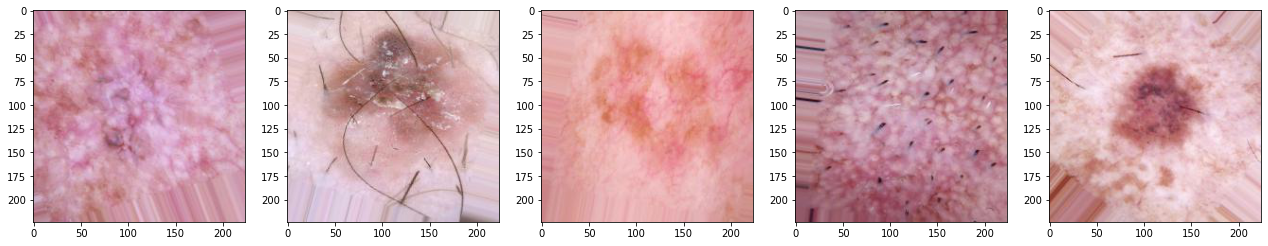

In [11]:
akiec_img = os.listdir(akiec_class)
# bcc_img = os.listdir(bcc_class)
# bkl_img = os.listdir(bkl_class)
# df_img = os.listdir(df_class)
# mel_img = os.listdir(mel_class)
# nv_img = os.listdir(nv_class)
# vasc_img = os.listdir(vasc_class)


plt.figure(figsize=(22, 5))
for i, img_path in enumerate(akiec_img[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(akiec_class, img_path))
    plt.imshow(img)
plt.show()

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [13]:
image_batch, label_batch = next(iter(train_data))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 2, 2, 1280)


In [14]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 32, 32, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 32, 32, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

## Add a classification head

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [16]:
prediction_layer = tf.keras.layers.Dense(7, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 7)


In [17]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              #optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 8967      
Total params: 2,266,951
Trainable params: 2,232,839
Non-trainable params: 34,112
_________________________________________________________________


In [19]:
len(model.trainable_variables)

158

In [21]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_data)

history = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=validation_data)

30/30 [==============================] - 9s 308ms/step - loss: 2.9770 - accuracy: 0.2665
Epoch 1/10
1206/1206 [==============================] - 239s 198ms/step - loss: 1.0076 - accuracy: 0.6214 - val_loss: 1.1841 - val_accuracy: 0.7281
Epoch 2/10
1206/1206 [==============================] - 223s 185ms/step - loss: 0.7472 - accuracy: 0.7201 - val_loss: 0.6298 - val_accuracy: 0.8539
Epoch 3/10
1206/1206 [==============================] - 220s 183ms/step - loss: 0.6151 - accuracy: 0.7678 - val_loss: 0.6460 - val_accuracy: 0.8497
Epoch 4/10
1206/1206 [==============================] - 219s 182ms/step - loss: 0.5308 - accuracy: 0.8038 - val_loss: 0.6981 - val_accuracy: 0.8667
Epoch 5/10
1206/1206 [==============================] - 221s 183ms/step - loss: 0.4518 - accuracy: 0.8317 - val_loss: 0.6405 - val_accuracy: 0.8753
Epoch 6/10
1206/1206 [==============================] - 219s 181ms/step - loss: 0.4050 - accuracy: 0.8493 - val_loss: 0.6037 - val_accuracy: 0.8710
Epoch 7/10
1206/1206 [=

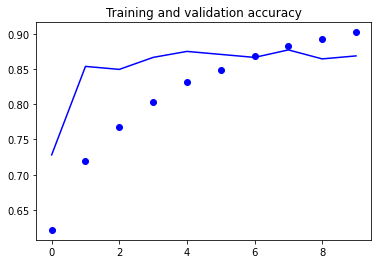

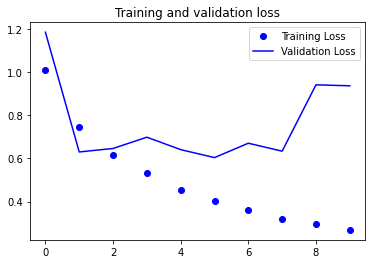

In [22]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(64, 64))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

Saving ISIC_0024462.jpg to ISIC_0024462 (1).jpg
ISIC_0024462.jpg
[[9.8695787e-26 2.2283365e-20 2.6686968e-07 5.7755951e-18 4.6458361e-17
  9.9999976e-01 9.9836182e-14]]


In [27]:
import time
saved_model_path = "./{}.h5".format(int(time.time()))

model.save(saved_model_path)

In [28]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 3.3MB/s 
     |████████████████████████████████| 112kB 5.8MB/s 
  Found existing installation: tensorflow-hub 0.12.0
    Uninstalling tensorflow-hub-0.12.0:
      Successfully uninstalled tensorflow-hub-0.12.0


In [30]:
!tensorflowjs_converter --input_format=keras {saved_model_path} ./

2021-05-12 05:59:22.789159: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
